By Jerry Lingjie Mei

In [1]:
using Images
using Colors

In [2]:
@inline function brightness(X::AbstractArray)
    m,n=size(X)
    B= zeros(Float32,m,n)
    for j =1:n
        @simd for i = 1:m
            @inbounds B[i,j]=X[i,j].r+X[i,j].g+X[i,j].b
        end
    end
    return B
end

brightness (generic function with 1 method)

In [3]:
@inline @inbounds function energy(A::Array{Float32,2})
    m,n=size(A)
    E= zeros(Float32,m,n)
    @simd for i in 1:m
        E[i,1]=E[i,n]=100000.0f0
    end
    for j in 2:n-1
        @simd for i in 2:m-1
            E[i,j] = sqrt(((A[i-1,j-1] + 2*A[i-1,j] + A[i-1,j+1]) - (A[i+1,j-1] + 2*A[i+1,j] + A[i+1,j+1]))^2 + ((A[i-1,j-1] + 2*A[i,j-1] + A[i+1,j-1]) - (A[i-1,j+1] + 2*A[i,j+1] + A[i+1,j+1]))^2)
        end
    end
    return E
end

In [4]:
@inline @inbounds function energy_block(E::Array{Float32,2}, A::Array{Float32,2},i::Int,j::Int)
    return sqrt(((A[i-1,j-1] + 2*A[i-1,j] + A[i-1,j+1]) - (A[i+1,j-1] + 2*A[i+1,j] + A[i+1,j+1]))^2 + ((A[i-1,j-1] + 2*A[i,j-1] + A[i+1,j-1]) - (A[i-1,j+1] + 2*A[i,j+1] + A[i+1,j+1]))^2)
end

In [5]:
@inbounds function get_seam(A::Array{Float32,2},E::Array{Float32,2},width::Int)
    m=size(A,1)
    E[:,1:width]=@views A[:,1:width]
    for i=1:m-1
        @simd for j=2:width-1
            s=E[i,j-1]
            if E[i,j]<s
                s=E[i,j]
            end
            if E[i,j+1]<s
                s=E[i,j+1]
            end
            E[i+1,j]+=s
        end
    end
    seam=zeros(Int, m)
    seam[m] = findmin(@views E[m,1:width])[2]
    j=seam[m]
    @simd for i in m-1:-1:1
        if E[i,j-1]<=E[i,j] && E[i,j-1]<=E[i,j+1]
            j-=1
        elseif E[i,j]>=E[i,j+1]
            j+=1
        end
        seam[i]=j
    end
    return seam
end

In [36]:
@inbounds function carve_seam!(img::AbstractArray,b::Array{Float32,2},e::Array{Float32,2},seam::Array{Int,1},width::Int)
    m= size(img,1)
    for i = 1:m
        @simd for j = seam[i]:width-1
            b[i,j] = b[i,j+1]
        end
        @simd for j = seam[i]:width-1
            img[i,j] = img[i,j+1]
        end
        @simd for j = seam[i]:width-1
            e[i,j] = e[i,j+1]
        end
    end
    for i=2:m-1
        @simd for j=max(2,seam[i]-2):min(seam[i]+1,width-2)
            e[i,j]=energy_block(e,b,i,j)
        end
    end
end

In [41]:
function carve_image(img::AbstractArray, Nseams::Int)
    new_img = deepcopy(img)
    m,n = size(img)
    b = brightness(img)
    e = energy(b)
    f = deepcopy(e)
    for i = 1:Nseams
        s = get_seam(e,f,n+1-i)
        carve_seam!(new_img,b,e,s,n+1-i)
    end
    return new_img[:,1:n-Nseams]
end

carve_image (generic function with 1 method)

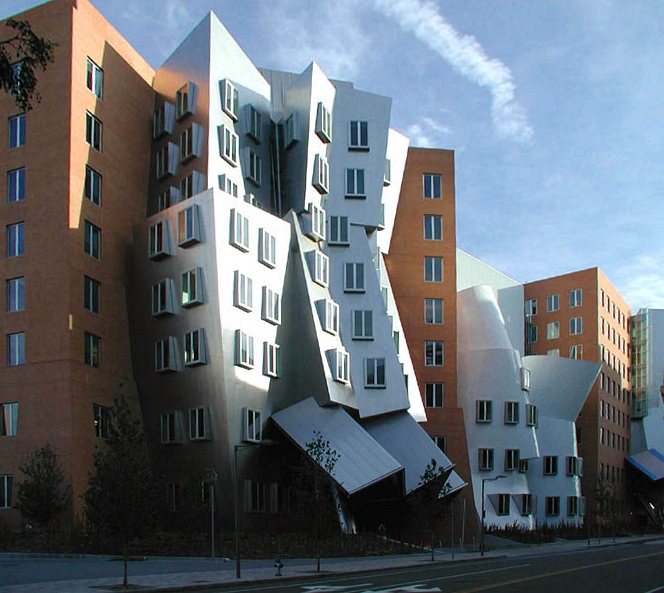

In [8]:
img = load("Wfm_stata_center.jpg")

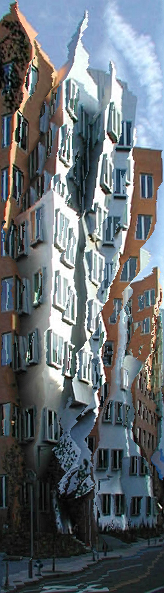

In [51]:
carve_image(img,500)

In [10]:
using BenchmarkTools

In [52]:
d=width(img)-2
@benchmark carve_image($img,$d)

BenchmarkTools.Trial: 
  memory estimate:  9.24 MiB
  allocs estimate:  3325
  --------------
  minimum time:     458.589 ms (0.00% GC)
  median time:      482.347 ms (0.00% GC)
  mean time:        482.370 ms (0.09% GC)
  maximum time:     505.434 ms (0.23% GC)
  --------------
  samples:          11
  evals/sample:     1